# Data Analysis Interview Challenge

### Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­ minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
file1 = 'logins.json'

In [3]:
df = pd.read_json(file1)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df['login_time'] = pd.to_datetime(df['login_time'])
df = df.set_index('login_time')
df['counts'] = 0

#The dataframe which gives the login counts per each 15 mins
df_15T = df.resample('15min').count()
df_15T['intervals'] = df_15T.index.strftime('%H:%M:%S') 
df_15T.head()

,counts,intervals
login_time,,
1970-01-01 20:00:00,2,20:00:00
1970-01-01 20:15:00,6,20:15:00
1970-01-01 20:30:00,9,20:30:00
1970-01-01 20:45:00,7,20:45:00
1970-01-01 21:00:00,1,21:00:00


In [5]:
#The dataframe which gives the mean of login counts of all days per 15 minuites 
df_final = df_15T.groupby(['intervals']).mean()
df_final.head()

,counts
intervals,
00:00:00,14.107843
00:15:00,15.166667
00:30:00,14.950980
00:45:00,14.529412
01:00:00,15.186275


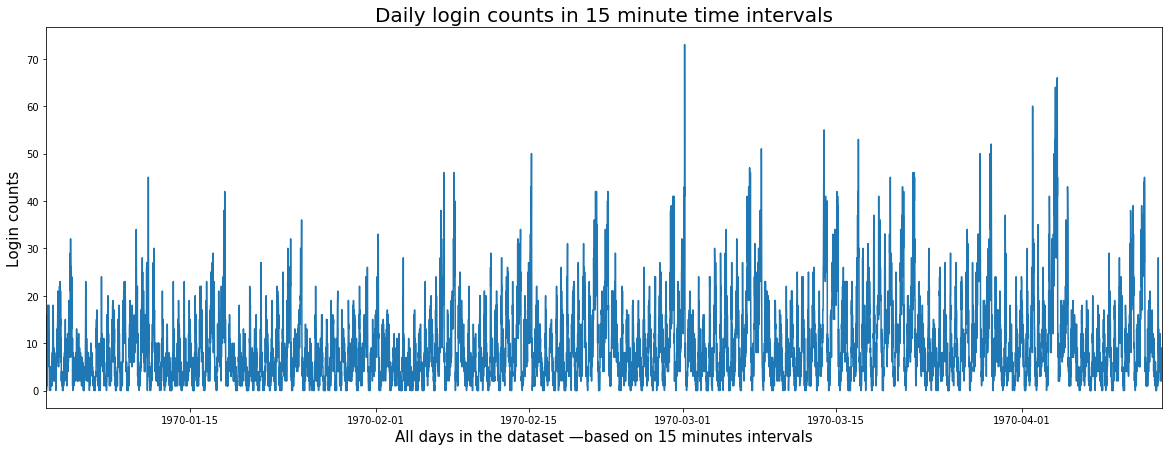

In [6]:
fig = plt.figure(figsize=(20,7))
plt.plot(df_15T.index, df_15T.counts)

plt.xlabel('All days in the dataset —based on 15 minutes intervals', fontsize=15)
plt.ylabel('Login counts', fontsize=15)
plt.title('Daily login counts in 15 minute time intervals', fontsize=20)
plt.xlim(pd.Timestamp(df_15T.index[0]), pd.Timestamp(df_15T.index[-1]))

plt.show()

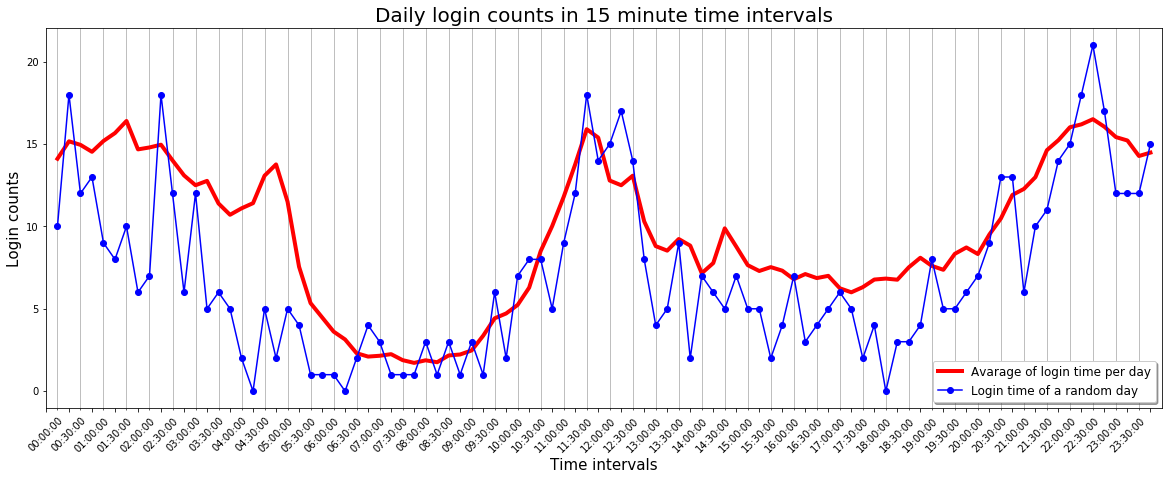

In [7]:
fig, ax = plt.subplots(figsize=(20,7))

plt.plot(range(len(df_final.index)), df_final.counts, 'r-', linewidth=4, label='Avarage of login time per day')
plt.plot(range(len(df_final.index)), df_15T.counts[16:112], 'ob-', label='Login time of a random day')

plt.xticks(np.arange(-1, len(df_final.index), step=2), df_final.index[::2], rotation=45)
ax.tick_params(axis='x', which='minor')
ax.set_xticks(np.arange(0, len(df_final.index), 1), minor=True)
ax.xaxis.grid(True, which='minor')


plt.legend(loc='lower right', shadow=True, fontsize=12)
plt.xlabel('Time intervals', fontsize=15)
plt.ylabel('Login counts', fontsize=15)
plt.title('Daily login counts in 15 minute time intervals', fontsize=20)
plt.xlim(-1, 96)

plt.show()


## Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
 - how you will implement the experiment
 - what statistical test(s) you will conduct to verify the significance of the
observation
 - how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


#### Answer:
The goal of the experiment is to encourage the driver partners to be available in both cities. One way to check this is to survey *the daily diversity* of locations each driver has been —either started from or travel to.

Let's label each location with the following:
- From or to Gotham as $G=1$
- From or to Metropolis as $M=-1$

Then we can define our metric $\xi$ to be:
\begin{equation*}
\xi = 1 - \left| \frac{\sum{G}}{N}+\frac{\sum{M}}{N} \right|
\end{equation*}
where $N= \sum{\left| G \right|} + \sum{\left| M \right|}$ is the total number of locations, and $\xi$ is the meric of diversity which is bound to $0\leq\xi\leq1$. A $\xi=0$ means that all the trips happened in one city, and $\xi=1$ means that the number of trips that happend in each city is equal (for example, among 4 rides the driver had 2 rides in city $G$ and two in city $M$, or the driver had 4 rides between the two cities).

Having the start and destination of rides for each driver we can simply generate their $\xi$ score. A mean of this score as $\xi_{mean}$ is a direct indicator of success or  failure of the experiment; the higher the $\xi_{mean}$ is the more driver spent their time between the two cities, and the lower $\xi_{mean}$ means they were excluded to one city!

## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
 2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
 3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [8]:
file2 = 'ultimate_data_challenge.json'
with open(file2, 'r') as datafile:
    data2 = json.load((open(file2)))
df = pd.DataFrame(data2)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### Part3-1.
`df['actactive_time']` is how many days costumers were active after the cutout date:

In [9]:
cutout_date = pd.to_datetime(max(df['last_trip_date'])) - timedelta(days=30)
df['active_time'] = pd.to_datetime(df['last_trip_date']) - cutout_date

active_time_list = []
for i in range(len(df['active_time'])):
    active_time_list.append(df['active_time'][i].days)
    
#updating the column to numeric values 
df['active_time'] = active_time_list  

x = len(df[df['active_time'].values<0])/len(df)
print('The percentage of customers who did NOT retain is {:6.3f}'.format(x*100))


The percentage of customers who did NOT retain is 62.392


Now we can create labels which indicated whether or not where *active* or not; actives are labeled by 1 and non-active ones by 0.

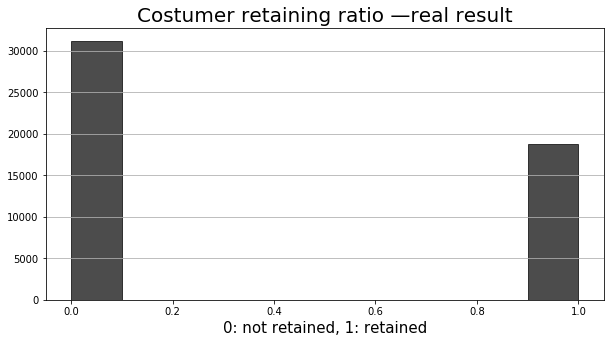

In [10]:
# 0 stands for costumer who did not retained
df['label'] = np.where(df['active_time']<0, 0, 1)
df['ultimate_black_user'] = np.where(df['ultimate_black_user']==True, 1, 0)


fig, ax = plt.subplots(figsize=(10,5))
plt.hist(df.label, alpha=0.7, histtype='bar', ec='black', facecolor='k')
plt.title('Costumer retaining ratio —real result', size=20)
plt.xlabel('0: not retained, 1: retained', fontsize=15)
ax.yaxis.grid(True)
plt.show()

### Part3-2.
Before creating a model we should get rid of the missing values (NaN). If I remove all the rows containing NaNs the dataframe will be shrunk, thus it is not a good option. Instead I replace them with the mean value of their corresponding columns which would keep the integrity of the data, and would not make a big impact on the trends.

Next I convert `city` and `phone` columns to categorical values (since their values are not numeric), then I drop the unnecessary columns.

In [11]:
df = df.fillna(df.mean())

In [12]:
df_origin = pd.get_dummies(df['city'])
df_phone = pd.get_dummies(df['phone'])
df_new = pd.concat([df, df_origin, df_phone], axis=1, join='inner')
df_new.drop(['city', 'signup_date', 'last_trip_date', 'phone'], axis=1, inplace=True)


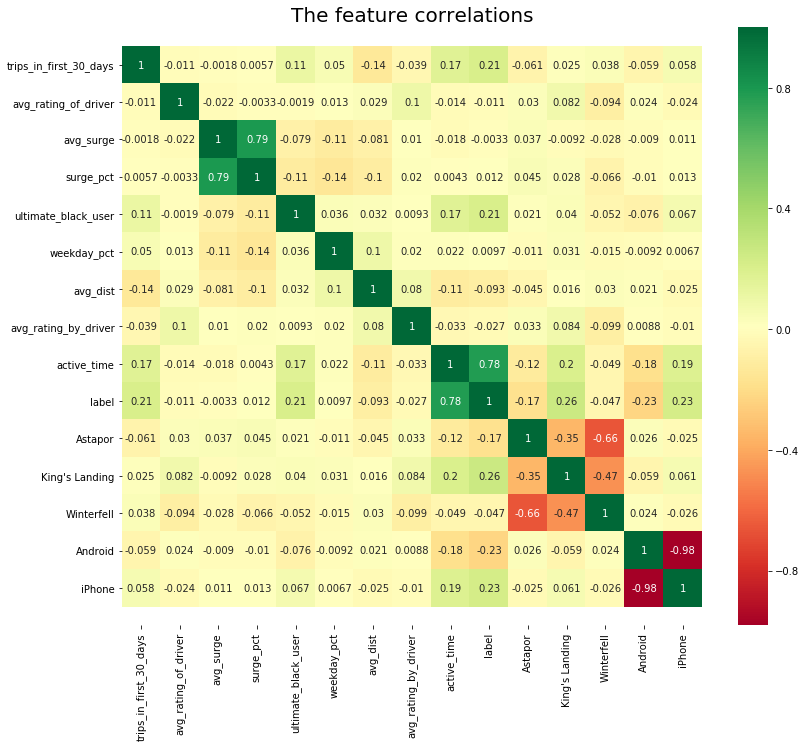

In [13]:
fig, ax = plt.subplots(figsize=(13,11))
g = sns.heatmap(df_new.corr(method='pearson'), cmap='RdYlGn', annot=True, annot_kws={'size': 10}) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.title('The feature correlations', fontsize=20)
plt.show()


The figure above shows the correlations between all the variables in our dataframe. What we are interested in is predicting the labels; whether customers would retain (1) or not (0). In other word based on our knowledge how likely a costumer would retain. 
Our target value is `label` and the rest are the features. `active_time` shows the number of days a costumer was active or not, this variable is almost synonymous to the `label`, hence, in order to not mislead our model I drop it. 

The strategy is as follows: 
- We create a model 
- Compare its predicted retained customers with the real retained customer percentage 
- We analyze the model with its important features 
- We carry on until we find a better prediction result

### *The first model: Logistic Regression*

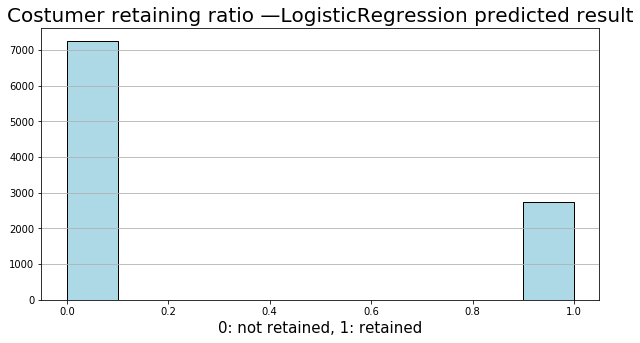

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df_new.drop(['label', 'active_time'], axis=1).values
y = df_new['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=104)


logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

retained_logreg = np.count_nonzero(y_pred)/len(y_test)*100
retained_real = np.count_nonzero(y)/len(y)*100

fig, ax = plt.subplots(figsize=(10,5))
plt.hist(y_pred, histtype='bar', ec='black', color='lightblue')
plt.title('Costumer retaining ratio —LogisticRegression predicted result', size=20)
plt.xlabel('0: not retained, 1: retained', fontsize=15)
ax.yaxis.grid(True)
plt.show()


In [15]:
print('\nThe Logistic Regression predicted retained percentage is {:6.2f} \
      \nThe real retained percentage is {:6.2f}\n'.
      format(retained_logreg, retained_real))


The Logistic Regression predicted retained percentage is  27.42       
The real retained percentage is  37.61



In [16]:
coefs = abs(list(logreg.coef_)[0])
features = list(df_new.drop(['label', 'active_time'], axis=1).columns)
feat_dic = {k: v for k, v in zip(features, coefs)}
feats = pd.DataFrame.from_dict(feat_dic, orient='index',columns=['coefs'])
feats = feats.sort_values('coefs',ascending=False)
feats

,coefs
King's Landing,0.984383
ultimate_black_user,0.865265
Astapor,0.717839
iPhone,0.617496
Android,0.451411
Winterfell,0.222331
avg_rating_by_driver,0.159511
avg_surge,0.120456
trips_in_first_30_days,0.118435
avg_rating_of_driver,0.064515


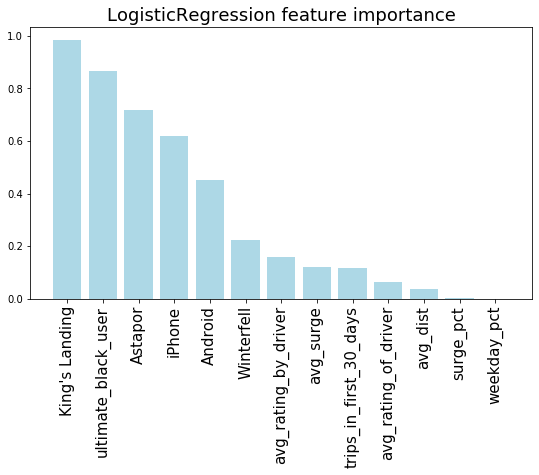

In [17]:
fig, ax = plt.subplots(figsize=(9,5))
plt.bar(feats.index, feats.coefs, color='lightblue')
plt.xticks(fontsize=15, rotation=90)
plt.title('LogisticRegression feature importance', size=18)
plt.show()

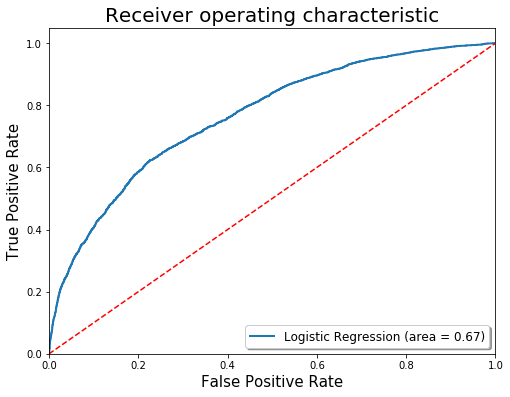

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc, linewidth=2)
plt.plot([0, 1], [0, 1],'r--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Receiver operating characteristic', size=20)
plt.legend(loc='lower right', shadow=True, fontsize=12)
plt.show()

Let's improve our model by Cross Validation:

In [19]:
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(logreg, X, y, cv=10)

retained_logreg_cv = np.count_nonzero(y_pred_cv)/len(y)*100

print('\nThe Logistic Regression CV predicted retained percentage is {:6.2f} \
      \nThe real retained percentage is {:6.2f}\n'.
      format(retained_logreg_cv, retained_real))


The Logistic Regression CV predicted retained percentage is  27.76       
The real retained percentage is  37.61



The result is *slight* improved but not that much!

In [20]:
from sklearn.metrics import classification_report

y_pred = logreg.predict(X_test)
target_names = ['label 0', 'label 1']

print('{} LogisticRegression report {}\n'.format(13*'=', 13*'='))
print(classification_report(y_test, y_pred, target_names=target_names))


============= LogisticRegression report =============

              precision    recall  f1-score   support

     label 0       0.74      0.86      0.79      6255
     label 1       0.67      0.49      0.57      3745

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000



### *The second model: Gradient Boosting*

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

X = df_new.drop(['label', 'active_time'], axis=1).values
y = df_new['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

retained_gbc = np.count_nonzero(y_pred_gbc)/len(y_test)*100

In [22]:
print('\nThe Gradient Boosting predicted retained percentage is {:6.2f} \
      \nThe real retained percentage is {:6.2f}\n'.
      format(retained_gbc, retained_real))


The Gradient Boosting predicted retained percentage is  33.55       
The real retained percentage is  37.61



Let's see if we can improve this model too:

In [23]:
y_pred_gbc_cv = cross_val_predict(gbc, X, y, cv=10)
retained_gbc_cv = np.count_nonzero(y_pred_gbc_cv)/len(y)*100

In [24]:
print('\nThe Gradient Boosting CV predicted retained percentage is {:6.2f} \
      \nThe Gradient Boosting predicted retained percentage is {:6.2f} \
      \nThe Logistic Regression CV predicted retained percentage is {:6.2f} \
      \nThe Logistic Regression predicted retained percentage is {:6.2f} \
      \nThe real retained percentage is {:6.2f}\n'.
      format(retained_gbc_cv, retained_gbc, retained_logreg_cv, retained_logreg, retained_real))


The Gradient Boosting CV predicted retained percentage is  33.61       
The Gradient Boosting predicted retained percentage is  33.55       
The Logistic Regression CV predicted retained percentage is  27.76       
The Logistic Regression predicted retained percentage is  27.42       
The real retained percentage is  37.61



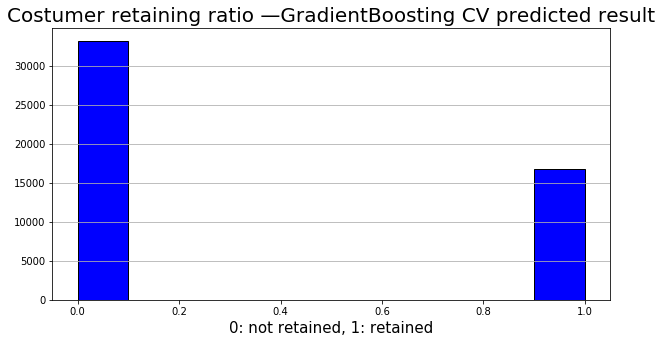

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(y_pred_gbc_cv, histtype='bar', ec='black', color='b')
plt.title('Costumer retaining ratio —GradientBoosting CV predicted result', size=20)
plt.xlabel('0: not retained, 1: retained', fontsize=15)
ax.yaxis.grid(True)
plt.show()

In [26]:
coefs = gbc.feature_importances_
features = list(df_new.drop(['label', 'active_time'], axis=1).columns)
feat_dic = {k: v for k, v in zip(features, coefs)}
feats_gbc = pd.DataFrame.from_dict(feat_dic, orient='index',columns=['coefs'])
feats_gbc = feats_gbc.sort_values('coefs',ascending=False)
feats_gbc

,coefs
avg_rating_by_driver,0.256763
surge_pct,0.171570
King's Landing,0.165553
weekday_pct,0.151938
ultimate_black_user,0.068883
Android,0.057841
trips_in_first_30_days,0.041148
iPhone,0.030378
Astapor,0.024896
avg_dist,0.016734


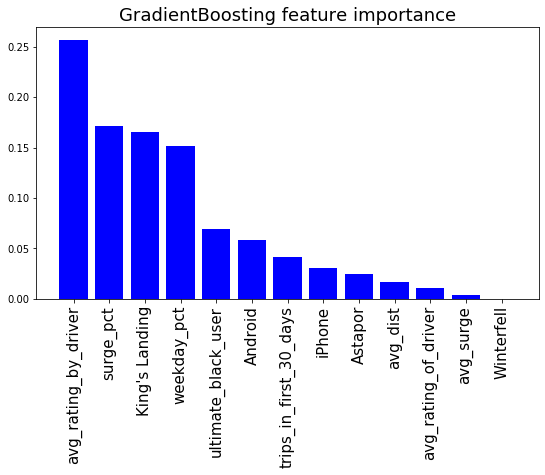

In [27]:
fig, ax = plt.subplots(figsize=(9,5))
plt.bar(feats_gbc.index, feats_gbc.coefs, color='b')
plt.xticks(fontsize=15, rotation=90)
plt.title('GradientBoosting feature importance', size=18)
plt.show()

In [28]:
print('{} GradientBoosting report {}\n'.format(14*'=', 14*'='))
print(classification_report(y, y_pred_gbc_cv, target_names=target_names))

============== GradientBoosting report ==============

              precision    recall  f1-score   support

     label 0       0.81      0.86      0.83     31196
     label 1       0.74      0.66      0.70     18804

    accuracy                           0.79     50000
   macro avg       0.78      0.76      0.77     50000
weighted avg       0.78      0.79      0.78     50000



From the above analysis, we found that `GradientBoosting` with cross validation worked the best. The real retained customer percentage is 37.61 and this model predicted 33.61. The classification report of the Gradient Boosting shows a higher precision of classification as compared to Logistic Regression. Also the classification report suggests the accuracy of label 0 (not retained costumers) is higher than level 1, which is a good thing for not overestimating the customers. 

### Part3-3.

We have a sorted list of important features, `feats_gbc`, based on which we can deduce how to encourage customers to retain.

For example: `avg_rating_by_driver` plays the most important role in retaining the customers. It means we can motivate the customers to stay by having the drivers to give them higher rates. 

Or `ultimate_black_user` shows that customers who took Ultimate Black tend to retain more than others. We can take advantage of this and spend more advertising for these riders.

The list indicates the location (which city) where the customers are located or what type of phones they use also have strong correlations with whether or not they retain.

## Data description
- **city**: city this user signed up in
- **phone**: primary device for this user
- **signup_date**: date of account registration; in the form ‘YYYY MM DD’
- **last_trip_date**: the last time this user completed a trip; in the form ‘YYYY MM DD’
- **avg_dist**: the average distance in miles per trip taken in the first 30 days after signup
- **avg_rating_by_driver**: the rider’s average rating over all of their trips
- **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips
- **surge_pct**: the percent of trips taken with surge multiplier > 1
- **avg_surge**: The average surge multiplier over all of this user’s trips
- **trips_in_first_30_days**: the number of trips this user took in the first 30 days after
signing up
- **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- **weekday_pct**: the percent of the user’s trips occurring during a weekday